# ICS 471 project -  Sign Language Recognition

This project is done by:

- Suhaib Abdulrahim Abdullatif `201821340`
- Omar Jarallah Alghamdi `201855000`


Sign language recognition is the task of recognizing the sign gesture in a video stream and outputting
its equivalent word or label. This problem is a branch of video captioning tasks. Each video consists
of a single sign.

In this project, you will develop a recognition system to recognize the sign in each sign video of the
KArSL dataset. KArSL is an Arabic sign language dataset. There are three versions of this dataset
KArSL-100, KArSL-190, and KArSL-502. In this project, you will work on KArSL-100 which consists
of 100 signs. The dataset was performed by three signers and each signer repeated each sign several
times. The videos are already converted into frames (18 frames for each video) and the structure of the
dataset is as follows:
- Signer ID (ex. 01 for signer 01)
    - Train
        - 0071 (sign folder)
            - Video#1 Frames folder (ex. 03_01_00071_(01_12_15_52_44))
                - frame1.jpg
                - frame2.jpg
                - ….
            - Video#1 Frames folder
                - frame1.jpg
                - frame2.jpg
                - ….
            - ……
        - 0072
        - ….
    - Test

In this project, you need to develop a deep learning model for sign language recognition. You should
report the accuracy in the signer-dependent and signer-independent modes. In signer-dependent mode,
you train the system and test it using samples from the same signer using the Train and Test folders of
that signer. In signer-independent mode, you train the system on two signers and test it on the third
signer.

## Step 1: Import the important libraries

In [1]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import random
import os
from matplotlib.image import imread
from keras import layers
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, LSTM, Reshape, Lambda, Flatten
from keras.utils import Sequence

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt


import cv2

2022-12-21 19:11:24.896079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Step 2: Prepare the data

### Read the labels

In [65]:
translation_labels = pd.read_excel('KARSL-100_Labels.xlsx')

In [66]:
translation_labels.head()

,SignID,Sign-Arabic,Sign-English
0,71,هيكل عظمي,Skeleton
1,72,جمجة,skull
2,73,عمود فقري,Backbone
3,74,قفص صدري,Chest
4,75,جهاز تنفسي,Respiratory device


Get the minimum label to map the IDs

In [67]:
MINIMUM_SIGN_ID = translation_labels['SignID'].min()
MINIMUM_SIGN_ID

71

We map the IDS so we can use them to predict the sign, since we have used the sparse categorical entropy

In [68]:
translation_labels['SignID'] = translation_labels['SignID'].map(lambda x: x - MINIMUM_SIGN_ID)
translation_labels.head()

,SignID,Sign-Arabic,Sign-English
0,0,هيكل عظمي,Skeleton
1,1,جمجة,skull
2,2,عمود فقري,Backbone
3,3,قفص صدري,Chest
4,4,جهاز تنفسي,Respiratory device


### Intialize `load_data` function

This function reads video data from a folder, pads the video frames to a fixed length, and returns the videos and their labels as numpy arrays.

In [4]:
def load_data(folder_name):
    
    # Get a list of the files in the directory containing the frames
    labels_files = [f for f in os.listdir(folder_name) if not f.startswith('.')]

    # Sort the files in ascending order by file name
    labels_files.sort()

    # Initialize an empty list to store the frames
    videos = []
    labels = []

    # Loop through the frame files
    for label_file in labels_files:

        label = label_file

        # Get a list of the video files in the current label folder
        videos_files = [f for f in os.listdir(os.path.join(folder_name, label_file)) if not f.startswith('.')]

        # Loop through the video files
        for video_name in videos_files:

            # Initialize an empty list to store the frames
            frames = []

            # Get a list of the frame files in the current video folder
            frames_files = [f for f in os.listdir(os.path.join(folder_name, label_file, video_name)) if not f.startswith('.')]

            # Loop through the frame files
            for frame_file in frames_files:

                # Load the frame using imread()
                frame = imread(os.path.join(folder_name, label_file, video_name, frame_file))

                # Resize the frame
                frame = cv2.resize(frame, (224, 224))

                # Append the frame to the list
                frames.append(frame)

            # Stack the frames along the first dimension to create a video array
            arr = np.stack(frames, axis=0)

            # Desired shape
            shape = (15, 224, 224, 3)

            # Calculate the padding needed along the first dimension
            pad_width = [(0, shape[0] - arr.shape[0])] + [(0, 0) for _ in range(arr.ndim - 1)]

            # Pad the array using the 'edge' mode
            padded_arr = np.pad(arr, pad_width, mode='edge')

            # Append the padded array to the list of videos
            videos.append(padded_arr)

            # Append the label of the video to the list of labels
            labels.append(label)

    # Stack the videos along the first dimension to create a videos array
    x = np.stack(videos, axis=0)

    # Stack the labels along the first dimension to create a labels array
    y = np.stack(labels, axis=0)
    
    # Return the videos and their labels
    return x, y

### Intialize `get_new_folder_path` function

This function generates the full path to a subfolder within a specified folder. The subfolder is identified by its type(`train`, `test`) and `label`, and the function creates it if it doesn't exist. The function returns the full path of the subfolder.

In [5]:
def get_new_folder_path(folder_name, type, label):

     # Get the current working directory
     r_path = os.getcwd()

     # Concatenate the name of the new directory to be created with the name of the original folder
     directory = 'extracted' + '_'+ folder_name

     # Join the current working directory, the new directory name, and the type and label subdirectories to create the full path
     path = os.path.join(r_path, directory, type, label)

     # Check if the path already exists
     if not os.path.exists(path):

          # If the path doesn't exist, create it using makedirs()
          os.makedirs(path)

          # Print a message indicating that the path has been created
          print('The path ', path, ' has been generated.')
          
     # Return the full path     
     return path

This code defines a function called `extract_features` that takes in two arguments: `model` and `video`. The function first uses the `model` object to predict the features of the `video`. Then, the function returns the extracted features.

In [6]:
def extract_features(model, video):

  # Extract the features using the pretrained CNN
  features = model.predict(video)

  # Return the extracted features
  return features

### Intialize `save_extract_features` function

This function extracts features from a dataset of videos and saves them to a series of CSV files. It performs the following steps:

1. It starts by printing a message indicating that the feature extraction process has started.

2. It initializes a counter variable to keep track of the video number and a variable to store the current label.

3. It loops through the data and labels arrays, using `zip()` to pair them up. For each iteration, it extracts the features from the current data point using the `extract_features()` function and stores them in the `video` variable.

4. It gets the path of the new folder for the current label and type using the `get_new_folder_path()` function.

5. It saves the extracted features to a CSV file in the new folder using `np.savetxt()`. It uses the counter variable to give each file a unique name.

6. It updates the counter variable with each iteration.

7. After the loop has finished running, it prints a message indicating that the extraction process has completed.

In [7]:
def save_extract_features(model, folder_name, type, data, labels):
    print('Starting feature extraction...')

    # Initialize a counter variable to keep track of the video number
    counter = 1

    # Initialize a variable to store the current label
    label = ''

    # Loop through the data and labels arrays
    for x, y in zip(data, labels):

        # Check if the current label is different from the previous one
        if(label != y):

            #  If the label has changed, update the label variable and reset the counter
            label = y
            counter = 1
        
        # Get the path of the new folder for the current label and type
        video_path = get_new_folder_path(folder_name, type, y)

        # Extract the features from the current data point
        video = extract_features(model, np.array(x))

        # Save the extracted features to a CSV file in the new folder
        np.savetxt(os.path.join(video_path, "{}.csv".format(counter)), video, delimiter=",")

        # Update the counter with each iteration
        counter +=1
        
    print("Extraction completed")

### Intialize `model_cnn_load` function

This function called `model_cnn_load` that loads a pre-trained VGG16 model from the ImageNet dataset and returns a new model using the inputs and output of the second-to-last layer of the original model. The VGG16 model is initialized with pre-trained weights and the top layers are included. The output of the second-to-last layer is obtained and used to create a new model using the inputs of the original model. The new model is returned.

In [8]:
# Loading the VGG16 model
def model_cnn_load():
    
    # Initialize the VGG16 model with pre-trained weights on the ImageNet dataset and include the top layers
    model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

    # Get the output of the second-to-last layer of the model
    out = model.layers[-2].output

    # Create a new model using the inputs of the VGG16 model and the output of the second-to-last layer
    model = Model(inputs=model.input, outputs=out)

    # Return the new model
    return model

In [9]:
cnn_model = model_cnn_load()

2022-12-21 02:01:45.818964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Load the raw data of the training videos for the first signer.

In [11]:
# trainx_1, trainy_1 = load_data('01/train')

Extract the videos features and save it into CSV files.

In [12]:
# save_extract_features(cnn_model, '01', 'train', trainx_1, trainy_1)

Load the raw data of the training videos for the second signer.

In [13]:
# trainx_2, trainy_2 = load_data('02/train')

Extract the videos features and save it into CSV files.

In [14]:
# save_extract_features(cnn_model, '02', 'train', trainx_2, trainy_2)

Load the raw data of the training videos for the third signer.

In [15]:
# trainx_3, trainy_3 = load_data('03/train')

Extract the videos features and save it into CSV files.

In [16]:
# save_extract_features(cnn_model, '03', 'train', trainx_3, trainy_3)

Load the raw data of the testing videos for the first signer.

In [17]:
# testx_1, testy_1 = load_data('01/test')

Extract the videos features and save it into CSV files.

In [18]:
# save_extract_features(cnn_model, '01', 'test', testx_1, testy_1)

Load the raw data of the testing videos for the second signer.

In [19]:
# testx_2, testy_2 = load_data('02/test')

Extract the videos features and save it into CSV files.

In [20]:
# save_extract_features(cnn_model, '02', 'test', testx_2, testy_2)

Load the raw data of the testing videos for the third signer.

In [21]:
# testx_3, testy_3 = load_data('03/test')

Extract the videos features and save it into CSV files.

In [22]:
# save_extract_features(cnn_model, '03', 'test', testx_3, testy_3)

### Intialize `CSVBatchGenerator` class

The `CSVBatchGenerator` class is used to generate batches of data from a set of CSV files stored in a root directory. When an instance of the `CSVBatchGenerator` class is created, it takes the following arguments:

- `root_dir`: the root directory where the CSV files are stored.

- `batch_size`: the number of CSV files to include in each batch.

- `shuffle`: a boolean indicating whether to shuffle the order of the CSV files before generating batches.

- `split`: a float between 0 and 1 indicating the proportion of the CSV files to use for training, the remainder is used for validation.

- `mode`: a string that specifies whether the generator is in "train", "validation", or "test" mode.

The `CSVBatchGenerator` class has the following methods:

- `get_all_samples`: returns all the data and labels in terms of x and y.

- `get_all_csv_files`: returns a list of all CSV file paths in the root directory.

- `on_epoch_end`: is called at the end of each epoch and shuffles the file paths if specified.

- `__len__`: returns the number of batches.

- `__getitem__`: returns a batch of data, which consists of a list of numpy arrays (one array for each CSV file in the batch) and a list of labels (one label for each CSV file in the batch).

The `__getitem__` method first selects the appropriate list of CSV file paths to use based on the generator's mode (either the training file paths, the validation file paths, or the test file paths). It then shuffles the file paths if the `shuffle` argument was set to `True`. Finally, it reads in each CSV file in the batch and extracts the data and label for each file, adding them to the `X` and `y` lists, respectively. The `X` and `y` lists are then returned as a tuple.

In [41]:
import random

class CSVBatchGenerator(Sequence):
  # Initialize the batch generator
  def __init__(self, root_dir, batch_size, shuffle=True, split = 0.0, mode='train'):
    # Set the root directory, batch size, and mode as instance variables
    self.root_dir = root_dir
    self.batch_size = batch_size
    self.mode = mode
    # Get the list of CSV file paths
    self.csv_file_paths = self.get_all_csv_files()
    self.shuffle = shuffle

    # Shuffle the list of CSV file paths if shuffle is True
    random.seed(777)
    if self.shuffle:
      self.csv_file_paths = random.shuffle(self.csv_file_paths)
    
    # Split the file paths into a training set and a validation set
    n = len(self.csv_file_paths)
    split_index = int(n * (1 - split))
    self.train_csv_file_paths = self.csv_file_paths[:split_index]
    self.valid_csv_file_paths = self.csv_file_paths[split_index:]
  
  def get_all_samples(self):
   
    csv_file_paths = None

    # If the generator is for the validation set, use the list of validation file paths
    # Otherwise, use the list of training file paths
    if self.mode == 'validation':
      csv_file_paths = self.valid_csv_file_paths
    elif self.mode == 'train':
      csv_file_paths = self.train_csv_file_paths
    elif self.mode == 'test': 
      csv_file_paths = self.csv_file_paths
    X, y = [], []  # Initialize empty lists for the data and labels
    # Iterate through the CSV file paths 
    for csv_file_path in csv_file_paths:
      # Read in the CSV file as a numpy array using np.genfromtxt
      data = np.genfromtxt(csv_file_path, delimiter=',')
      # Extract the label from the file path and convert it to an integer
      label = int(csv_file_path.split('/')[-2])
      # Add the data and label to the lists
      X.append(data)
      y.append(int(label) - MINIMUM_SIGN_ID)
    # Stack the data and labels into numpy arrays along the first axis
    X = np.stack(X, axis=0)
    y = np.stack(y, axis=0)
    # Return the data and labels
    return X, y

  # Get a list of all CSV files in the root directory
  def get_all_csv_files(self):
    file_paths = []  # Initialize an empty list to store the file paths
    # Iterate through all directories, subdirectories, and files in the root directory
    for dir_path, _, file_names in os.walk(self.root_dir):
      # Iterate through all file names
      for file_name in file_names:
        # Construct the full file path by joining the current working directory, directory path, and file name
        file_path = os.path.join(os.getcwd(), dir_path, file_name)
        # If the file is a CSV file, append it to the list of file paths
        if file_path.endswith('.csv'):
          file_paths.append(file_path)
    # Return the list of file paths
    return file_paths

  def on_epoch_end(self):
    #To control the randomness of the generation
    random.seed(int(random.randint(0, 2**32)))
    if self.shuffle:
      if self.mode == 'validation':
        self.valid_csv_file_paths = random.shuffle(self.valid_csv_file_paths)
      elif self.mode == 'train':
        self.train_csv_file_paths = random.shuffle(self.train_csv_file_paths)
      elif self.mode == 'test': 
        self.csv_file_paths = random.shuffle(self.csv_file_paths)

  # Return the number of batches
  def __len__(self):
    # Calculate the number of batches by dividing the number of CSV file paths by the batch size
    if self.mode == 'validation':
      return len(self.valid_csv_file_paths) // self.batch_size
    elif self.mode == 'train':
      return len(self.train_csv_file_paths) // self.batch_size
    elif self.mode == 'test': 
      return len(self.csv_file_paths) // self.batch_size

  # Get a batch of data
  def __getitem__(self, idx):
    # Calculate the start and end indices for the batch
    start = idx * self.batch_size
    end = start + self.batch_size
    
    csv_file_paths = None

    # If the generator is for the validation set, use the list of validation file paths
    # Otherwise, use the list of training file paths
    if self.mode == 'validation':
      csv_file_paths = self.valid_csv_file_paths
    elif self.mode == 'train':
      csv_file_paths = self.train_csv_file_paths
    elif self.mode == 'test': 
      csv_file_paths = self.csv_file_paths

    # Get the list of CSV file paths for the current batch
    batch_csv_file_paths = csv_file_paths[start:end]

    X, y = [], []  # Initialize empty lists for the data and labels
    # Iterate through the CSV file paths in the batch
    for csv_file_path in batch_csv_file_paths:
      # Read in the CSV file as a numpy array using np.genfromtxt
      data = np.genfromtxt(csv_file_path, delimiter=',')
      # Extract the label from the file path and convert it to an integer
      label = int(csv_file_path.split('/')[-2])
      # Add the data and label to the lists
      X.append(data)
      y.append(int(label) - MINIMUM_SIGN_ID)
    # Stack the data and labels into numpy arrays along the first axis
    X = np.stack(X, axis=0)
    y = np.stack(y, axis=0)
    # Return the data and labels
    return X, y

### Intialize `CombinedBatchGenerator` class

The `CombinedBatchGenerator` class is a generator that combines the data from two other generators, `generator1` and `generator2`. The class is implemented using the `Sequence` class from the `keras.utils` module, which allows it to be used with the `fit` function from the `keras` library.

- `__init__`: initializes the generator by setting `generator1` and `generator2` as instance variables.

- `__len__`: returns the total number of batches in the combined generator, which is calculated by adding the number of batches in `generator1` and `generator2`.

- ` __getitem__`: returns the data for a specific batch by indexing the corresponding generator. If the index is less than the number of batches in `generator1`, it returns the data from `generator1`, otherwise it returns the data from `generator2`.

In [5]:
class CombinedBatchGenerator(Sequence):
  def __init__(self, generator1, generator2):
    self.generator1 = generator1
    self.generator2 = generator2
    
  def __len__(self):
    return len(self.generator1) + len(self.generator2)
  
  def __getitem__(self, index):
    if index < len(self.generator1):
      return self.generator1[index]
    else:
      return self.generator2[index - len(self.generator1)]

### Creating train, validation and test generators for each signer

In [147]:
# Determine the validation ratio and batch size

VAL_RATIO = 0.2
BATCH_SIZE = 32

Create train, val and test generators for signer #1

In [148]:
train_generator1 = CSVBatchGenerator('extracted_01/train', batch_size=BATCH_SIZE, shuffle=True, split = VAL_RATIO, mode = 'train')
val_generator1 = CSVBatchGenerator('extracted_01/train', batch_size=BATCH_SIZE, shuffle=True, split = VAL_RATIO, mode = 'validation')
test_generator1 = CSVBatchGenerator('extracted_01/test', batch_size=BATCH_SIZE, shuffle=False, mode = 'test')

Create train, val and test generators for signer #2

In [149]:
train_generator2 = CSVBatchGenerator('extracted_02/train', batch_size=BATCH_SIZE, shuffle=True, split = VAL_RATIO, mode = 'train')
val_generator2 = CSVBatchGenerator('extracted_02/train', batch_size=BATCH_SIZE, shuffle=True, split = VAL_RATIO, mode = 'validation')
test_generator2 = CSVBatchGenerator('extracted_02/test', batch_size=BATCH_SIZE, shuffle=False, mode = 'test')

Create train, val and test generators for signer #3

In [150]:
train_generator3 = CSVBatchGenerator('extracted_03/train', batch_size=BATCH_SIZE, shuffle=True, split = VAL_RATIO, mode = 'train')
val_generator3 = CSVBatchGenerator('extracted_03/train', batch_size=BATCH_SIZE, shuffle=True, split = VAL_RATIO, mode = 'validation')
test_generator3 = CSVBatchGenerator('extracted_03/test', batch_size=BATCH_SIZE, shuffle=False, mode = 'test')

Combine train and val for signer #2 and #3

In [151]:
train_generator_23 = CombinedBatchGenerator(train_generator2, train_generator3)
val_generator_23 = CombinedBatchGenerator(val_generator2, val_generator3)

Combine train and val for signer #1 and #3

In [152]:
train_generator_13 = CombinedBatchGenerator(train_generator1, train_generator3)
val_generator_13 = CombinedBatchGenerator(val_generator1, val_generator3)

Combine train and val for signer #1 and #2

In [153]:
train_generator_12 = CombinedBatchGenerator(train_generator1, train_generator2)
val_generator_12 = CombinedBatchGenerator(val_generator1, val_generator2)

## Step 3: Building the model

Since videos are ordered sequences of frames, we need our Transformer model to take into account order information. We do this via **positional encoding**. We simply embed the positions of the frames present inside videos with an `Embedding` layer. We then add these positional embeddings to the precomputed CNN feature maps.

### Intialize `PositionalEmbedding` class

The `PositionalEmbedding` class is a custom layer in `TensorFlow` that adds position embeddings to the input data. It generates a tensor of positions, applies an Embedding layer to them to get the embeddings, and then adds the embeddings to the input tensor.

- `__init__`: initializes the layer with the given `sequence_length` and `output_dim` parameters, as well as an `Embedding` layer that maps positions to embeddings. The `sequence_length` and `output_dim` parameters are stored as instance variables.

- `call`: takes a tensor of shape `(batch_size, frames, num_features)` as input, and returns a tensor of the same shape with the position embeddings added. It generates a tensor of positions using the `tf.range` function, and then applies the `Embedding` layer to the positions to get the embeddings. Finally, it adds the embeddings to the input tensor and returns the result.

- `compute_mask`: takes an input tensor and a mask, and returns a mask that indicates which elements in the input tensor are valid. It does this by casting the input tensor to a boolean tensor and then reducing it along the last axis using the `tf.reduce_any` function. This results in a boolean tensor of shape `(batch_size, frames)` where True values indicate that at least one feature in that time step is valid.

In [12]:
class PositionalEmbedding(layers.Layer):

    # Initialize the layer with the given sequence_length and output_dim parameters
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)

        # Create an Embedding layer that maps positions to embeddings
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )

        # Store the sequence_length and output_dim as instance variables
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        
        # The inputs are of shape: `(batch_size, frames, num_features)`
        # Get the length of the inputs along the frames axis
        length = tf.shape(inputs)[1]

        # Generate a tensor of positions using the tf.range function
        positions = tf.range(start=0, limit=length, delta=1)

        # Apply the Embedding layer to the positions to get the embeddings
        embedded_positions = self.position_embeddings(positions)

        # Add the embeddings to the inputs and return the result
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):

        # Create a boolean tensor by casting the inputs to bool
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)

        # Return the mask
        return mask

### Intialize `TransformerEncoder` class

This code defines a class called `TransformerEncoder` which represents an encoder in a transformer model. The `TransformerEncoder` class has several attributes and methods:

- `__init__`: This is the constructor for the `TransformerEncoder` class. It takes four arguments: `embed_dim`, `dense_dim`, `num_heads`, and `**kwargs`. `embed_dim` represents the size of the embedding vectors. `dense_dim` represents the size of the dense layers. `num_heads` represents the number of attention heads. `**kwargs` is a catch-all for any additional keyword arguments that may be passed to the constructor.

- `call`: This method defines the forward pass of the `TransformerEncoder`. It takes two arguments: `inputs` and `mask`. `inputs` is a tensor of shape `(batch_size, sequence_length, embed_dim)` representing the input sequence. `mask` is a tensor of shape `(batch_size, sequence_length)` representing the attention mask. The method first applies the attention layer to the inputs, using the attention mask if provided. It then applies a normalization layer and a dense projection layer to the input sequence. Finally, it returns the output of the final normalization layer.

The `TransformerEncoder` class also has several attributes:

- `embed_dim`: The size of the embedding vectors.
- `dense_dim`: The size of the dense layers.
- `num_heads`: The number of attention heads.
- `attention`: A multi-headed attention layer.
- `dense_proj`: A sequence of two dense layers, with the first layer using the GELU activation function.
- `layernorm_1`: A layer normalization layer.
- `layernorm_2`: A layer normalization layer.

In [13]:
class TransformerEncoder(layers.Layer):

    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):

        # Call the base class constructor
        super().__init__(**kwargs)

        # Initialize attributes
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Create a multi-headed attention layer
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )

        # Create a sequence of two dense layers, with the first layer using the GELU activation function
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )

        # Create two layer normalization layers
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):

        # Optionally apply the attention mask
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        # Apply the attention layer to the inputs
        attention_output = self.attention(inputs, inputs, attention_mask=mask)

        # Normalize the input sequence and add the attention output
        proj_input = self.layernorm_1(inputs + attention_output)

        # Apply the dense projection layer
        proj_output = self.dense_proj(proj_input)

        # Normalize the input sequence and add the projection output
        return self.layernorm_2(proj_input + proj_output)

### Intialize `get_compiled_model` function

`get_compiled_model()` function defines and returns a compiled transformer model for video classification. The model has an embedding layer, a transformer encoder, a global max pooling layer, a dropout layer, and a dense output layer with a softmax activation. The model is compiled with the Adam optimizer, a sparse categorical crossentropy loss function, and an accuracy metric.

In [276]:
def get_compiled_model():
    sequence_length = 18 # Number of frames per video
    embed_dim = 4096 # Number of features per frame
    dense_dim = 4 # Size of dense layers
    num_heads = 2 # Number of attention heads
    classes = 100 # Number of classes

    # Define the input layer
    inputs = keras.Input(shape=(None, None))

    # Add a positional embedding layer
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)

    # Add a transformer encoder layer
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)

    # Add a global max pooling layer
    x = layers.GlobalMaxPooling1D()(x)

    # Add a dropout layer
    x = layers.Dropout(0.5)(x)

    # Add a dense output layer with a softmax activation
    outputs = layers.Dense(classes, activation="softmax")(x)

    # Create the model
    model = keras.Model(inputs, outputs)

    # Compile the model with the Adam optimizer, a sparse categorical crossentropy loss function, and an accuracy metric
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

`flatten` function flatten takes a single argument `lst`, which is a list of lists. The function returns a flat list containing all of the elements in `lst`, recursively flattening sublists if they exist.

In [204]:
def flatten(lst):
    flat_list = []
    for sublist in lst:
        flat_list.extend(sublist.flatten())
    return flat_list

In [266]:
def print_report(model, generator):
    true_labels = [ y for (x,y) in generator]
    flattened = flatten(true_labels)
    p_predictions = model.predict(generator)
    predictions = np.argmax(p_predictions, axis=1).tolist()
    return classification_report(flattened, predictions)
    

In [230]:
def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

## Step 4: Training and evaluating the model

In this project, you need to develop a deep learning model for sign language recognition. You should
report the accuracy in the signer-dependent and signer-independent modes. In signer-dependent mode,
you train the system and test it using samples from the same signer using the Train and Test folders of
that signer. In signer-independent mode, you train the system on two signers and test it on the third
signer. You should report the results as follows:

**1. Signer-dependent**

Signer | Accuracy 
-------|----------
01     | 
02     | 
03     | 

**2. Signer-independent**

Signer | Accuracy 
-------|----------
01 (trained on 02,03)| 
02 (trained on 01,03)| 
03 (trained on 01,02)| 

## A. Signer-dependant 

### Signer 01

In [277]:
model_1 = get_compiled_model()
model_1.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None, None)]      0         
                                                                 
 frame_position_embedding (P  (None, None, 4096)       73728     
 ositionalEmbedding)                                             
                                                                 
 transformer_layer (Transfor  (None, None, 4096)       134299652 
 merEncoder)                                                     
                                                                 
 global_max_pooling1d_13 (Gl  (None, 4096)             0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_13 (Dropout)        (None, 4096)              0         
                                                          

In [278]:

results_1 = model_1.fit(
        train_generator1,
        validation_data=val_generator1,
        epochs=50,
        callbacks=[keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/50
 8/87 [=>............................] - ETA: 10:26 - loss: 9.2128 - accuracy: 0.0078

In [ ]:
signer1 = model_1.evaluate(test_generator1)

25/25 [==============================] - 101s 4s/step - loss: 0.8498 - accuracy: 0.8900


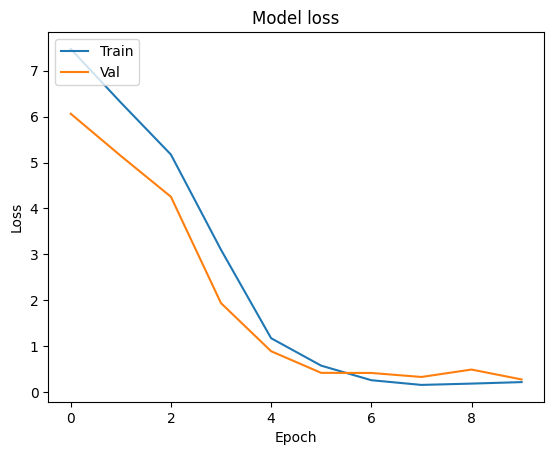

In [ ]:
plot_loss(results_1)

In [ ]:
print(print_report(model_1, test_generator1))

25/25 [==============================] - 101s 4s/step
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.89      1.00      0.94         8
           2       0.67      1.00      0.80         8
           3       1.00      1.00      1.00         8
           4       1.00      0.88      0.93         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       0.00      0.00      0.00         8
           8       1.00      1.00      1.00         8
           9       0.89      1.00      0.94         8
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      0.88      0.93         8
          16       1.00    

/Users/omaralghamdi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaralghamdi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaralghamdi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### Signer 02

In [ ]:
model_2 = get_compiled_model()

In [ ]:
results_2 = model_2.fit(
        train_generator2,
        validation_data=val_generator2,
        epochs=50,
        callbacks=[keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/10
89/89 [==============================] - 763s 8s/step - loss: 7.4701 - accuracy: 0.0140 - val_loss: 5.9962 - val_accuracy: 0.0043
Epoch 2/10
89/89 [==============================] - 738s 8s/step - loss: 6.3883 - accuracy: 0.0193 - val_loss: 5.4303 - val_accuracy: 0.0114
Epoch 3/10
89/89 [==============================] - 657s 7s/step - loss: 4.8451 - accuracy: 0.0794 - val_loss: 4.2080 - val_accuracy: 0.0938
Epoch 4/10
89/89 [==============================] - 658s 7s/step - loss: 2.8510 - accuracy: 0.3051 - val_loss: 2.0569 - val_accuracy: 0.4190
Epoch 5/10
89/89 [==============================] - 660s 7s/step - loss: 1.3354 - accuracy: 0.6162 - val_loss: 1.3981 - val_accuracy: 0.6477
Epoch 6/10
89/89 [==============================] - 656s 7s/step - loss: 0.6667 - accuracy: 0.8027 - val_loss: 0.5729 - val_accuracy: 0.8338
Epoch 7/10
89/89 [==============================] - 656s 7s/step - loss: 0.3957 - accuracy: 0.8968 - val_loss: 0.4193 - val_accuracy: 0.8977
Epoch 8/10
89

In [ ]:
signer_2 = model_2.evaluate(test_generator2)

25/25 [==============================] - 93s 4s/step - loss: 0.1833 - accuracy: 0.9500


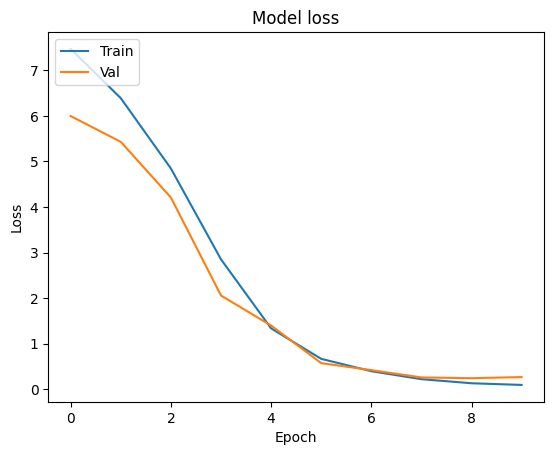

In [ ]:
plot_loss(results_2)

In [ ]:
print(print_report(model_2, test_generator2))

25/25 [==============================] - 99s 4s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       1.00      0.88      0.93         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         8
           9       1.00      0.50      0.67         8
          10       1.00      1.00      1.00         8
          11       0.89      1.00      0.94         8
          12       0.89      1.00      0.94         8
          13       1.00      1.00      1.00         8
          14       1.00      0.25      0.40         8
          15       0.53      1.00      0.70         8
          16       1.00     

### Signer 03

In [50]:
model_3 = get_compiled_model()

In [51]:
results_3 = model_3.fit(
        train_generator3,
        validation_data=val_generator3,
        epochs=15,
        callbacks=[keras.callbacks.EarlyStopping(patience=3)]
)



Epoch 1/15
88/88 [==============================] - 680s 8s/step - loss: 7.5684 - accuracy: 0.0096 - val_loss: 5.9153 - val_accuracy: 0.0071
Epoch 2/15
88/88 [==============================] - 673s 8s/step - loss: 6.3275 - accuracy: 0.0199 - val_loss: 5.6737 - val_accuracy: 0.0085
Epoch 3/15
88/88 [==============================] - 673s 8s/step - loss: 5.1379 - accuracy: 0.0760 - val_loss: 3.9511 - val_accuracy: 0.1605
Epoch 4/15
88/88 [==============================] - 670s 8s/step - loss: 2.3853 - accuracy: 0.4414 - val_loss: 1.3829 - val_accuracy: 0.6165
Epoch 5/15
88/88 [==============================] - 632s 7s/step - loss: 0.7919 - accuracy: 0.7830 - val_loss: 0.4523 - val_accuracy: 0.8764
Epoch 6/15
88/88 [==============================] - 636s 7s/step - loss: 0.3259 - accuracy: 0.9059 - val_loss: 0.4892 - val_accuracy: 0.8722
Epoch 7/15
88/88 [==============================] - 656s 7s/step - loss: 0.3603 - accuracy: 0.9023 - val_loss: 0.3802 - val_accuracy: 0.8849
Epoch 8/15
88

In [52]:
signer_3 = model_3.evaluate(test_generator3)

25/25 [==============================] - 95s 4s/step - loss: 0.1507 - accuracy: 0.9675


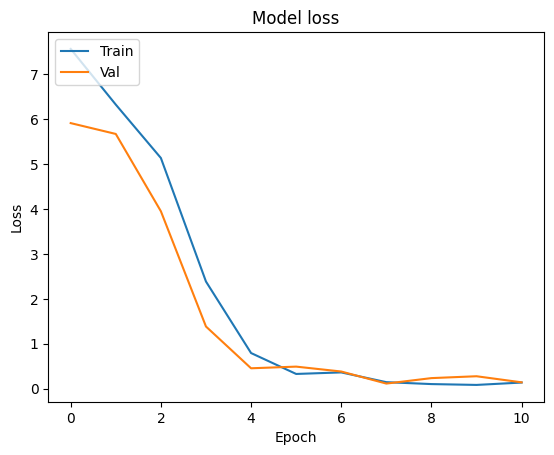

In [243]:
plot_loss(results_3)

In [253]:
print(print_report(model_3, test_generator3))

25/25 [==============================] - 97s 4s/step
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      0.62      0.77         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       0.80      1.00      0.89         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8
          11       0.80      1.00      0.89         8
          12       1.00      0.75      0.86         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      0.62      0.77         8
          16       1.00     

Signer | Accuracy % 
-------|----------
01     | 89.00
02     | 95.00
03     | 96.75

## b. Signer-independant 

### Signer 01

In [53]:
model_23 = get_compiled_model()

In [54]:
results_23 = model_23.fit(
        train_generator_23,
        validation_data=val_generator_23,
        epochs=15,
        callbacks=[keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/15
177/177 [==============================] - 1347s 8s/step - loss: 6.9026 - accuracy: 0.0124 - val_loss: 5.7913 - val_accuracy: 0.0085
Epoch 2/15
177/177 [==============================] - 1319s 7s/step - loss: 5.4594 - accuracy: 0.0470 - val_loss: 3.8934 - val_accuracy: 0.1463
Epoch 3/15
177/177 [==============================] - 1434s 8s/step - loss: 2.1912 - accuracy: 0.4507 - val_loss: 1.2974 - val_accuracy: 0.6506
Epoch 4/15
177/177 [==============================] - 1409s 8s/step - loss: 0.7315 - accuracy: 0.7821 - val_loss: 0.6081 - val_accuracy: 0.8125
Epoch 5/15
177/177 [==============================] - 1328s 7s/step - loss: 0.4160 - accuracy: 0.8799 - val_loss: 0.3853 - val_accuracy: 0.8906
Epoch 6/15
177/177 [==============================] - 1304s 7s/step - loss: 0.2082 - accuracy: 0.9350 - val_loss: 0.3254 - val_accuracy: 0.9091
Epoch 7/15
177/177 [==============================] - 1264s 7s/step - loss: 0.2203 - accuracy: 0.9347 - val_loss: 0.3715 - val_accuracy:

In [55]:
signer_1_23 = model_23.evaluate(test_generator1)

25/25 [==============================] - 88s 4s/step - loss: 10.6460 - accuracy: 0.1300


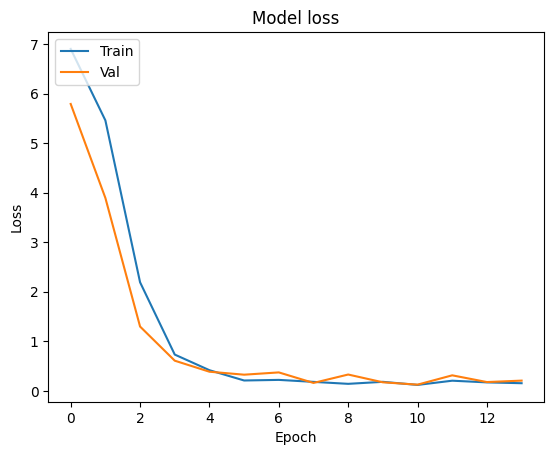

In [258]:
plot_loss(results_23)

In [259]:
print(print_report(model_23, test_generator1))

25/25 [==============================] - 100s 4s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.50      0.50      0.50         8
           2       0.14      0.12      0.13         8
           3       0.50      0.25      0.33         8
           4       0.10      0.12      0.11         8
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         8
          10       0.17      0.75      0.28         8
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         8
          13       0.14      0.12      0.13         8
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00         8
          16       0.00    

/Users/omaralghamdi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaralghamdi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaralghamdi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### Signer 02

In [56]:
model_13 = get_compiled_model()

In [57]:
results_13 = model_13.fit(
        train_generator_13,
        validation_data=val_generator_13,
        epochs=15,
        callbacks=[keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/15
175/175 [==============================] - 1262s 7s/step - loss: 7.0097 - accuracy: 0.0104 - val_loss: 5.6531 - val_accuracy: 0.0080
Epoch 2/15
175/175 [==============================] - 1246s 7s/step - loss: 5.9820 - accuracy: 0.0205 - val_loss: 4.9766 - val_accuracy: 0.0203
Epoch 3/15
175/175 [==============================] - 1252s 7s/step - loss: 3.5525 - accuracy: 0.2511 - val_loss: 1.4747 - val_accuracy: 0.5400
Epoch 4/15
175/175 [==============================] - 1248s 7s/step - loss: 1.1596 - accuracy: 0.6811 - val_loss: 0.6989 - val_accuracy: 0.7740
Epoch 5/15
175/175 [==============================] - 1251s 7s/step - loss: 0.4941 - accuracy: 0.8473 - val_loss: 0.3248 - val_accuracy: 0.8881
Epoch 6/15
175/175 [==============================] - 1249s 7s/step - loss: 0.2856 - accuracy: 0.9161 - val_loss: 0.3489 - val_accuracy: 0.8968
Epoch 7/15
175/175 [==============================] - 1305s 7s/step - loss: 0.2794 - accuracy: 0.9154 - val_loss: 0.2336 - val_accuracy:

In [59]:
signer_2_13 = model_13.evaluate(test_generator2)

25/25 [==============================] - 93s 4s/step - loss: 10.1327 - accuracy: 0.1262


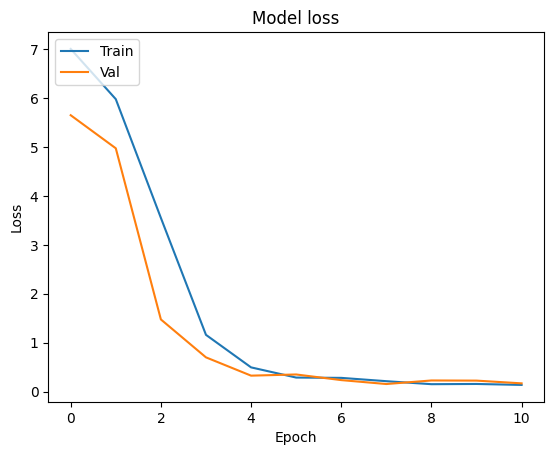

In [260]:
plot_loss(results_13)

In [261]:
print(print_report(model_13, test_generator2))

25/25 [==============================] - 107s 4s/step
              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.25      0.12      0.17         8
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         8
           7       0.28      0.88      0.42         8
           8       1.00      0.38      0.55         8
           9       0.00      0.00      0.00         8
          10       1.00      0.12      0.22         8
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         8
          14       0.08      0.12      0.10         8
          15       0.12      0.50      0.20         8
          16       0.00    

/Users/omaralghamdi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaralghamdi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaralghamdi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### Signer 03

In [60]:
model_12 = get_compiled_model()

In [61]:
results_12 = model_12.fit(
        train_generator_12,
        validation_data=val_generator_12,
        epochs=10,
        callbacks=[keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/10
176/176 [==============================] - 1351s 8s/step - loss: 7.0547 - accuracy: 0.0131 - val_loss: 5.6491 - val_accuracy: 0.0174
Epoch 2/10
176/176 [==============================] - 1310s 7s/step - loss: 5.8581 - accuracy: 0.0195 - val_loss: 4.9398 - val_accuracy: 0.0080
Epoch 3/10
176/176 [==============================] - 1309s 7s/step - loss: 3.8632 - accuracy: 0.1825 - val_loss: 2.3883 - val_accuracy: 0.3946
Epoch 4/10
176/176 [==============================] - 1337s 8s/step - loss: 1.5351 - accuracy: 0.5898 - val_loss: 0.9803 - val_accuracy: 0.7217
Epoch 5/10
176/176 [==============================] - 1337s 8s/step - loss: 0.6912 - accuracy: 0.8075 - val_loss: 0.7912 - val_accuracy: 0.7958
Epoch 6/10
176/176 [==============================] - 1318s 7s/step - loss: 0.4018 - accuracy: 0.8842 - val_loss: 0.3491 - val_accuracy: 0.8903
Epoch 7/10
176/176 [==============================] - 1339s 8s/step - loss: 0.2900 - accuracy: 0.9194 - val_loss: 0.2302 - val_accuracy:

In [62]:
signer_3_12 = model_12.evaluate(test_generator3)

25/25 [==============================] - 96s 4s/step - loss: 10.6032 - accuracy: 0.1663


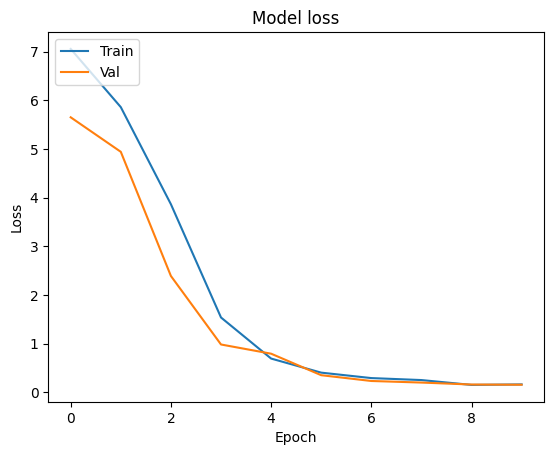

In [263]:
plot_loss(results_12)

Signer | Accuracy % 
-------|----------
01 (trained on 02,03)| 13.00
02 (trained on 01,03)| 12.62
03 (trained on 01,02)| 16.63

Saving the models to use them later if needed.

In [270]:
from keras.models import save_model
def save_models(models, directory):
    a_path =  os.path.join(os.getcwd(), directory)
    enumerate
    for i, model in enumerate(models):
        save_model(model, os.path.join(a_path, '{}.h5'.format(i+1)))

In [271]:
save_models([model_1, model_2, model_3, model_23, model_13, model_12], 'models')

/Users/omaralghamdi/Library/Python/3.9/lib/python/site-packages/keras/engine/functional.py:1564: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [122]:
def predict_arabic(model, directory):
    r_path = os.path.join(os.getcwd(), directory)
    # Read in the CSV file as a numpy array using np.genfromtxt
    data = np.genfromtxt(r_path, delimiter=',')
    data = np.expand_dims(data, axis=0)
    # Extract the label from the file path and convert it to an integer
    label = int(r_path.split('/')[-2]) - MINIMUM_SIGN_ID
    corresponding_label = translation_labels.loc[translation_labels['SignID'] == label, 'Sign-Arabic'].item()
    print('The true label is: ', corresponding_label)
    prediction = np.argmax(model.predict(data))
    corresponding_label = translation_labels.loc[translation_labels['SignID'] == prediction, 'Sign-Arabic'].item()
    print('The predicted label is: ', corresponding_label)
      

In [164]:
def predict_english(model, directory):
    r_path = os.path.join(os.getcwd(), directory)
    # Read in the CSV file as a numpy array using np.genfromtxt
    data = np.genfromtxt(r_path, delimiter=',')
    data = np.expand_dims(data, axis=0)
    # Extract the label from the file path and convert it to an integer
    label = int(r_path.split('/')[-2]) - MINIMUM_SIGN_ID
    corresponding_label = translation_labels.loc[translation_labels['SignID'] == label, 'Sign-English'].item()
    print('The true label is: ', corresponding_label)
    prediction = np.argmax(model.predict(data))
    corresponding_label = translation_labels.loc[translation_labels['SignID'] == prediction, 'Sign-English'].item()
    print('The predicted label is: ', corresponding_label)

Arabic prediction

In [165]:
predict_arabic(model_3, '/Users/omaralghamdi/ICS471-project/extracted_03/test/0071/1.csv')

The true label is:  هيكل عظمي
1/1 [==============================] - 0s 103ms/step
The predicted label is:  هيكل عظمي


English prediction

In [166]:
predict_english(model_3, 'extracted_03/test/0121/6.csv')

The true label is:  diabetes
1/1 [==============================] - 0s 100ms/step
The predicted label is:  diabetes


Work distribution:

- Omar Alghamdi: `50%`

- Suhaib Abdullatif: `50%`


# References

- [Video Classification with Transformers](https://keras.io/examples/vision/video_transformers/)
- [Write your own Custom Data Generator for TensorFlow Keras](https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3)